In [1]:
from astropy.table import Table
from astropy.table import join, vstack
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.patheffects as pe
from sklearn.neighbors import KernelDensity
import seaborn as sns
import copy

# plt.style.use("seaborn")

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family='serif')    # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['axes.axisbelow'] = True

# Create a black and white color map where bad data (NaNs) are white
cmap = copy.copy(plt.cm.plasma)
cmap.set_bad('w', 1.)

In [2]:
from KDEpy.bw_selection import silvermans_rule
import KDEpy


def kde2D(x_in, y_in, bw=None):
    x_in = np.asarray(x_in)
    y_in = np.asarray(y_in)
    data = np.array([x_in, y_in]).T
    if bw is not None:
        kde = KDEpy.FFTKDE(bw=bw)
        grid, points = kde.fit(data).evaluate(1024)
    else:
        bw1 = silvermans_rule(data[:, [0]])
        bw2 = silvermans_rule(data[:, [1]])
        data_scaled = data / np.array([bw1, bw2])
        kde = KDEpy.FFTKDE(bw=1)
        x_scaled, y_scaled = kde.fit(data_scaled).evaluate((1024, 1024))
        grid = x_scaled * np.array([bw1, bw2])
        points = y_scaled / (bw1 * bw2)
    x, y = np.unique(grid[:, 0]), np.unique(grid[:, 1])
    z = points.reshape(1024, 1024).T
    return x, y, z

In [3]:
# 恒星、类星体、星系三样本的plot

def fancypairplot(dataframe, x, y, xrange=None, yrange=None, 
                  bins=150, ax=None, xlabel=None, ylabel=None):
    df = dataframe.copy()
    df.dropna(subset=[x,y],inplace=True)
    df.reset_index(inplace=True,drop=True)
    dfs = df.query("`class`=='STAR'")
    dfg = df.query("`class`=='GALAXY'")
    dfq = df.query("`class`=='QSO'")
    xs = dfs[x].values
    ys = dfs[y].values
    xg = dfg[x].values
    yg = dfg[y].values
    xq = dfq[x].values
    yq = dfq[y].values
    xs_mean = np.nanmean(xs)
    ys_mean = np.nanmean(ys)
    xs_sigma = np.nanstd(xs)
    ys_sigma = np.nanstd(ys)
    xs_left = xs_mean - 4 * xs_sigma
    xs_right = xs_mean + 4 * xs_sigma
    ys_left = ys_mean - 3 * ys_sigma
    ys_right = ys_mean + 5 * ys_sigma
    if xrange is not None:
        xs_left = xrange[0]
        xs_right = xrange[1]
    if yrange is not None:
        ys_left = yrange[0]
        ys_right = yrange[1]
    H, xbins, ybins = np.histogram2d(
        xs, ys,
        bins=(np.linspace(xs_left, xs_right, bins),
              np.linspace(ys_left, ys_right, bins)))
#     ks = kde2D(xs, ys)
    kg = kde2D(xg, yg)
    kq = kde2D(xq, yq)
#     levels = np.logspace(-2, np.ceil(np.log10(ks[2].max())), 8)
#     levels = levels[levels>=0.01]
    levelsg = np.logspace(-1.5, np.ceil(np.log10(kg[2].max())), 8)
    levelsg = levelsg[levelsg>=0.01]
    levelsq = np.logspace(-1.5, np.ceil(np.log10(kq[2].max())), 8)
    levelsq = levelsq[levelsq>=0.01]
    x = df[x].values
    y = df[y].values
    if ax is None:
        ax = plt.gca()
#     ax.grid(zorder=0)
    im = ax.imshow(np.log10(H).T, origin='lower',
                   extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
                   cmap='Reds', 
                   interpolation='nearest',
                   aspect='auto',
                   label='STAR',
                   zorder=1)
#     cstar = ax.contour(ks[0], ks[1], ks[2], 
#                        levels=levels,
#                        colors=('w',),
#                        linewidths=(2.0,))
    cgal = ax.contour(kg[0], kg[1], kg[2],
                      levels=levelsg,
                      colors=('C2',),
                      linewidths=(1.5,),
#                       label='GALAXY',
                      zorder=2)
    cqso = ax.contour(kq[0], kq[1], kq[2],
                      levels=levelsq,
                      colors=('C0',),
                      linewidths=(2.0,),
#                       label='QSO',
                      zorder=3)
#     clbls = ax.clabel(cstar, fmt='%.2f', 
#                       colors='k', inline=False, 
#                     #   fontsize=14,
#                       use_clabeltext=True)
#     clblsg = ax.clabel(cgal, fmt='%.2f',
#                        colors='k', inline=False,
#                       #    fontsize=14,
#                        use_clabeltext=True)
#     clblsq = ax.clabel(cqso, fmt='%.2f',
#                        colors='k', inline=False,
#                        #    fontsize=14,
#                        use_clabeltext=True)
#     for clbl in [clbls, clblsg, clblsq]:
#         for lbl in clbl:
#             lbl.set_path_effects([pe.withStroke(linewidth=5, foreground="w")])
    # plt.setp(clbls, path_effects=[pe.withStroke(linewidth=5,
    #                                             foreground="w")])
    ax.set_xlim(xbins[0], xbins[-1])
    ax.set_ylim(ybins[0], ybins[-1])
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.minorticks_on()
    ax.legend([cqso.legend_elements()[0][0], 
               cgal.legend_elements()[0][0]], 
              ['QSO', 'GALAXY'], 
              loc=2,
              frameon=True,
              fancybox=True, 
              facecolor='w', 
              framealpha=0.4)
    return ax

In [4]:
# 只看一种星体的plot

def fancyplot(dataframe, x, y, xrange=None, yrange=None, 
                  bins=150, ax=None, xlabel=None, ylabel=None):
    df = dataframe.copy()
    df.dropna(subset=[x,y],inplace=True)
    df.reset_index(inplace=True,drop=True)
    x = df[x].values
    y = df[y].values
    x_mean = np.nanmean(x)
    y_mean = np.nanmean(y)
    x_sigma = np.nanstd(x)
    y_sigma = np.nanstd(y)
    x_left = x_mean - 4 * x_sigma
    x_right = x_mean + 4 * x_sigma
    y_left = y_mean - 3 * y_sigma
    y_right = y_mean + 5 * y_sigma
    if xrange is not None:
        x_left = xrange[0]
        x_right = xrange[1]
    if yrange is not None:
        y_left = yrange[0]
        y_right = yrange[1]
    H, xbins, ybins = np.histogram2d(
        x, y,
        bins=(np.linspace(x_left, x_right, bins),
              np.linspace(y_left, y_right, bins)))
    k = kde2D(x, y)
    levels = np.logspace(-1.5, np.ceil(np.log10(k[2].max())), 8)
    levels = levels[levels>=0.01]
#     x = df[x].values
#     y = df[y].values
    if ax is None:
        ax = plt.gca()
    c = ax.contour(k[0], k[1], k[2],
                      levels=levels,
                      colors=('C0',),
                      linewidths=(2.0,),
#                       label='QSO',
                      zorder=3)
    ax.set_xlim(xbins[0], xbins[-1])
    ax.set_ylim(ybins[0], ybins[-1])
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.minorticks_on()
    return ax

In [16]:
# 比较两种类星体和恒星训练样本的plot

def fancycompareplot(dataframe, x, y, xrange=None, yrange=None, 
                  bins=150, ax=None, xlabel=None, ylabel=None):
    df = dataframe.copy()
    df.dropna(subset=[x,y],inplace=True)
    df.reset_index(inplace=True,drop=True)
    dfs = df.query("`class`=='STAR'")
    dfm = df.query("`class`=='MockGPQ'")
    dfp = df.query("`class`=='PredGPQ'")
    xs = dfs[x].values
    ys = dfs[y].values
    xm = dfm[x].values
    ym = dfm[y].values
    xp = dfp[x].values
    yp = dfp[y].values
    xs_mean = np.nanmean(xs)
    ys_mean = np.nanmean(ys)
    xs_sigma = np.nanstd(xs)
    ys_sigma = np.nanstd(ys)
    xs_left = xs_mean - 4 * xs_sigma
    xs_right = xs_mean + 4 * xs_sigma
    ys_left = ys_mean - 3 * ys_sigma
    ys_right = ys_mean + 5 * ys_sigma
    if xrange is not None:
        xs_left = xrange[0]
        xs_right = xrange[1]
    if yrange is not None:
        ys_left = yrange[0]
        ys_right = yrange[1]
    H, xbins, ybins = np.histogram2d(
        xs, ys,
        bins=(np.linspace(xs_left, xs_right, bins),
              np.linspace(ys_left, ys_right, bins)))
    
    km = kde2D(xm, ym)
    kp = kde2D(xp, yp)

    levelsm = np.logspace(-1.5, np.ceil(np.log10(km[2].max())), 8)
    levelsm = levelsm[levelsm>=0.01]
    levelsp = np.logspace(-1.5, np.ceil(np.log10(kp[2].max())), 8)
    levelsp = levelsp[levelsp>=0.01]
    x = df[x].values
    y = df[y].values
    if ax is None:
        ax = plt.gca()
#     ax.grid(zorder=0)

    im = ax.imshow(np.log10(H).T, origin='lower',
                   extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
                   cmap='Reds', 
                   interpolation='nearest',
                   aspect='auto',
                   label='STAR',
                   zorder=1)
    cmock = ax.contour(km[0], km[1], km[2],
                      levels=levelsm,
                      colors=('C2',),
                      linewidths=(1.5,),
#                       label='MockGPQ',
                      zorder=2)
    cpred = ax.contour(kp[0], kp[1], kp[2],
                      levels=levelsp,
                      colors=('C0',),
                      linewidths=(2.0,),
#                       label='PredGPQ',
                      zorder=3)
    ax.set_xlim(xbins[0], xbins[-1])
    ax.set_ylim(ybins[0], ybins[-1])
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.minorticks_on()
    ax.legend([cmock.legend_elements()[0][0], 
               cpred.legend_elements()[0][0]], 
              ['MockGPQ', 'PredGPQ_30_colorcut'], 
              loc=2,
              frameon=True,
              fancybox=True, 
              facecolor='w', 
              framealpha=0.4)
    return ax

# 1. 看训练样本的颜色分布

In [8]:
df = pd.read_csv('/cargo/public/catdata/ml_train/train/trainingset_3class_test6.csv')

features = ['iz','zy','yj','jh','hk','iw1','zw1','yw1','jw1','hw1','kw1','w1w2']

<ipython-input-6-adfceda8f7fa>:45: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


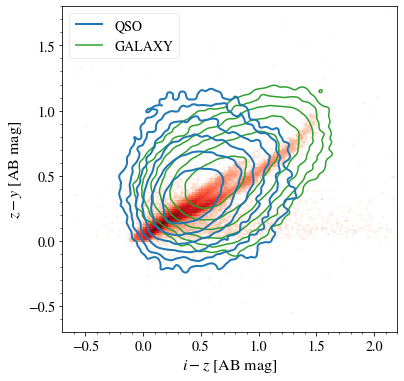

In [11]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancypairplot(df, 
                   "iz", "zy", 
                   ax=ax, 
                   xrange=[-0.7, 2.2],
                   yrange=[-0.7, 1.8],
                   xlabel=r"$i-z$ [AB mag]", 
                   ylabel=r"$z-y$ [AB mag]")

<ipython-input-6-adfceda8f7fa>:45: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


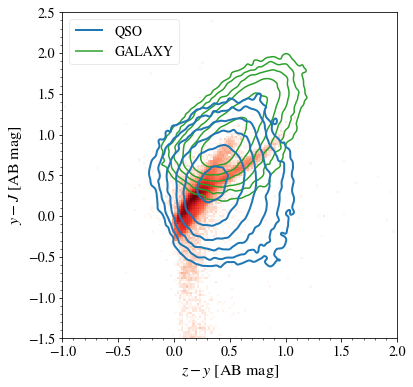

In [22]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancypairplot(df, 
                   "zy", "yj", 
                   ax=ax, 
                   xrange=[-1.0, 2.0],
                   yrange=[-1.5, 2.5],
                   xlabel=r"$z-y$ [AB mag]", 
                   ylabel=r"$y-J$ [AB mag]")

<ipython-input-25-f3cf66a84313>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


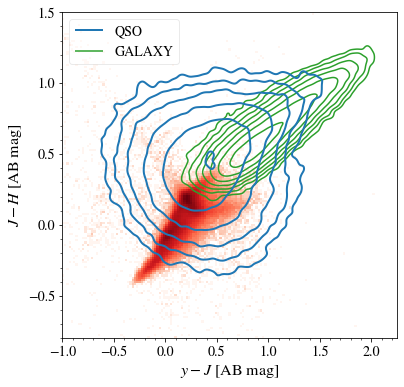

In [89]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancypairplot(df, 
                   "yj", "jh", 
                   ax=ax, 
                   xrange=[-1.0, 2.25],
                   yrange=[-0.8, 1.5],
                   xlabel=r"$y-J$ [AB mag]", 
                   ylabel=r"$J-H$ [AB mag]")

<ipython-input-25-f3cf66a84313>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


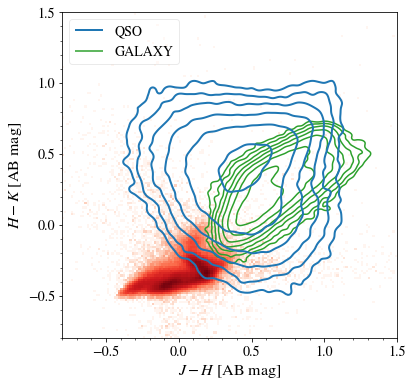

In [85]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancypairplot(df, 
                   "jh", "hk", 
                   ax=ax,
                   xrange=[-0.8, 1.5],
                   yrange=[-0.8, 1.5],
                   xlabel=r"$J-H$ [AB mag]", 
                   ylabel=r"$H-K$ [AB mag]")

<ipython-input-25-f3cf66a84313>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


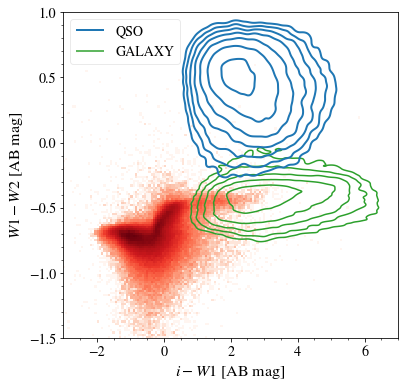

In [48]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancypairplot(df, 
                   "iw1", "w1w2", 
                   ax=ax,
                   xrange=[-3, 7],
                   yrange=[-1.5,1],
                   xlabel=r"$i-W1$ [AB mag]", 
                   ylabel=r"$W1-W2$ [AB mag]")

<ipython-input-25-f3cf66a84313>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


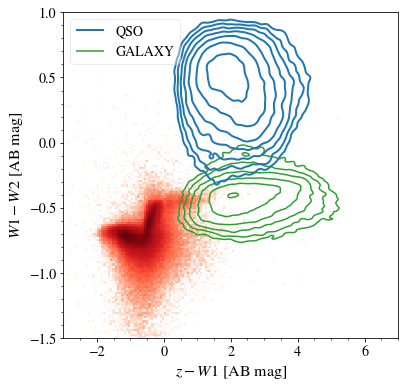

In [47]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancypairplot(df, 
                   "zw1", "w1w2", 
                   ax=ax,
                   xrange=[-3, 7],
                   yrange=[-1.5,1],
                   xlabel=r"$z-W1$ [AB mag]", 
                   ylabel=r"$W1-W2$ [AB mag]")

<ipython-input-25-f3cf66a84313>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


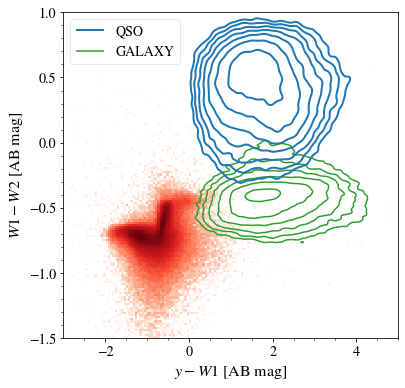

In [45]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancypairplot(df, 
                   "yw1", "w1w2", 
                   ax=ax,
                   xrange=[-3, 5],
                   yrange=[-1.5,1],
                   xlabel=r"$y-W1$ [AB mag]", 
                   ylabel=r"$W1-W2$ [AB mag]")

<ipython-input-25-f3cf66a84313>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


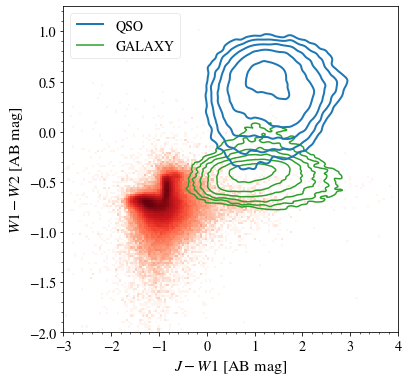

In [83]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancypairplot(df, 
                   "jw1", "w1w2", 
                   ax=ax,
                   xrange=[-3, 4],
                   yrange=[-2,1.25],
                   xlabel=r"$J-W1$ [AB mag]", 
                   ylabel=r"$W1-W2$ [AB mag]")

<ipython-input-25-f3cf66a84313>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


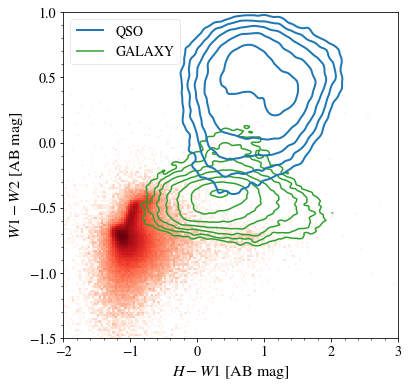

In [43]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancypairplot(df, 
                   "hw1", "w1w2", 
                   ax=ax,
                   xrange=[-2, 3],
                   yrange=[-1.5,1],
                   xlabel=r"$H-W1$ [AB mag]", 
                   ylabel=r"$W1-W2$ [AB mag]")

<ipython-input-3-d82b79d17e76>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


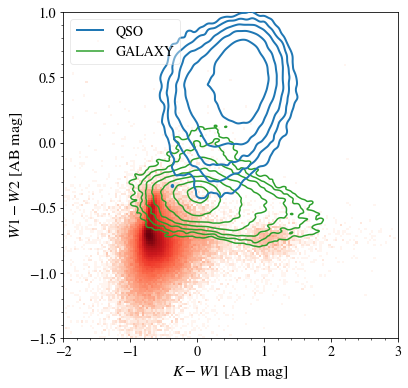

In [57]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancypairplot(df, 
                   "kw1", "w1w2", 
                   ax=ax,
                   xrange=[-2, 3],
                   yrange=[-1.5,1],
                   xlabel=r"$K-W1$ [AB mag]", 
                   ylabel=r"$W1-W2$ [AB mag]")

# 2. Pred GPQ的颜色分布

In [6]:
pred_gpq = pd.read_csv('/cargo/public/catdata/gpq_nir/density_map/combined_pred_gpq_30%.csv')
pred_gpq['class'] = 'QSO'
pred_gpq

,Unnamed: 0,ra,dec,l,b,gps_pstar,gps_pgalaxy,gps_pnoise,gps_psaturated,g,...,w1w2,ebv,n64pix,predict_proba_1,predict_proba_2,P_biased,n256pix,P_prior,P_real,class
0,960,100.500789,13.407676,199.918600,4.019919,0.993865,0.003067,0.003067,0,24.2566,...,0.582,0.336922,22798,0.999954,0.998392,0.998347,365625,0.051178,0.300547,QSO
1,961,100.500886,13.435664,199.893632,4.032686,0.999981,0.000010,0.000010,0,NaN,...,0.077,0.322054,22798,0.999823,0.999612,0.999434,365625,0.051178,0.300875,QSO
2,962,100.494848,13.375936,199.944338,4.000382,0.996753,0.003076,0.000171,0,NaN,...,0.563,0.354820,22798,0.998621,0.998328,0.996952,365625,0.051178,0.300127,QSO
3,964,100.490112,13.355003,199.960949,3.986788,0.486486,0.486486,0.027027,0,25.8567,...,0.623,0.358218,22798,0.999982,0.997233,0.997215,365625,0.051178,0.300206,QSO
4,1002,100.912813,13.575100,199.950650,4.452969,0.499230,0.499230,0.001541,0,29.8544,...,0.012,0.400194,22798,0.990453,0.993407,0.983923,362552,0.055566,0.321602,QSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28586,1145571,96.375528,22.397129,190.102819,4.635717,0.993865,0.003067,0.003067,0,25.5593,...,0.174,0.546491,22535,0.999898,0.996471,0.996369,361501,0.063691,0.373295,QSO
28587,1145572,96.377020,22.422562,190.080819,4.648675,0.900000,0.050000,0.050000,0,27.6759,...,0.638,0.571089,22535,0.999827,0.998384,0.998212,361501,0.063691,0.373986,QSO
28588,1145575,96.397162,22.399364,190.110087,4.654495,0.993865,0.003067,0.003067,0,23.4025,...,0.435,0.546491,22535,0.999994,0.999879,0.999872,361501,0.063691,0.374608,QSO
28589,1145576,96.398171,22.403769,190.106598,4.657354,0.999981,0.000010,0.000010,0,24.4769,...,0.187,0.546491,22535,0.999842,0.999576,0.999418,361501,0.063691,0.374438,QSO


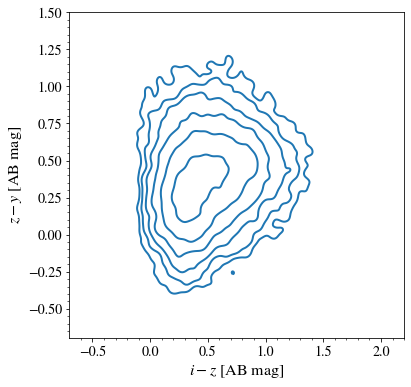

In [49]:
f, ax = plt.subplots(figsize=(6, 6))

ax = fancyplot(pred_gpq, 
               "iz", "zy", 
               ax=ax,
               xrange=[-0.7, 2.2],
               yrange=[-0.7, 1.5],
               xlabel=r"$i-z$ [AB mag]", 
               ylabel=r"$z-y$ [AB mag]")

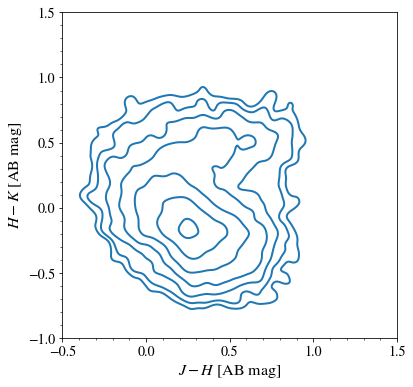

In [50]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancyplot(pred_gpq, 
               "jh", "hk", 
               ax=ax,
               xrange=[-0.5, 1.5],
               yrange=[-1.0, 1.5],
               xlabel=r"$J-H$ [AB mag]", 
               ylabel=r"$H-K$ [AB mag]")

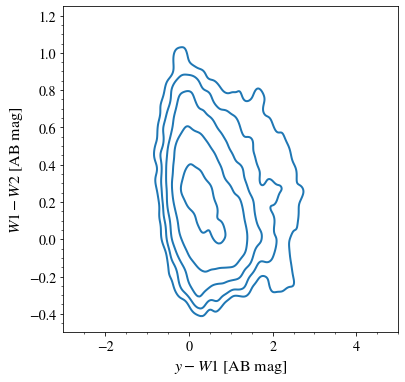

In [53]:
f, ax = plt.subplots(figsize=(6, 6))
# ax.set_aspect("equal")

ax = fancyplot(pred_gpq, 
               "yw1", "w1w2", 
               ax=ax,
               xrange=[-3, 5],
               yrange=[-0.5,1.25],
               xlabel=r"$y-W1$ [AB mag]", 
               ylabel=r"$W1-W2$ [AB mag]")

# 3. 把不同颜色图画在一张图上

## 3.1 test6 训练样本

In [9]:
feature_pairs=[['iz', 'zy'],
               ['zy','yj'],
               ['yj','jh'],
               ['jh','hk'],
               ['yw1', 'w12'],
               ['jw1','w12']
              ]

In [12]:
feature_dict = {}

feature_dict['izy'] = {'x': 'iz', 
                       'y': 'zy',
                       'xrange': [-0.5, 1.8],
                       'yrange': [-0.5, 2.0],
                       'xlabel': r'$i-z$',
                       'ylabel': r'$z-y$'}
feature_dict['zyj'] = {'x': 'zy', 
                       'y': 'yj',
                       'xrange':[-0.7, 1.5],
                       'yrange':[-1.75, 3.0],
                       'xlabel':r"$z-y$ [AB mag]", 
                       'ylabel':r"$y-J$ [AB mag]"}
feature_dict['yjh'] = {'x': 'yj', 
                       'y': 'jh',
                       'xrange':[-1.5, 2.5],
                       'yrange':[-0.8, 2.0],
                       'xlabel':r"$y-J$ [AB mag]", 
                       'ylabel':r"$J-H$ [AB mag]"}
feature_dict['jhk'] = {'x': 'jh', 
                       'y': 'hk',
                      'xrange':[-1, 1.5],
                       'yrange':[-1, 2.0],
                       'xlabel':r"$J-H$ [AB mag]", 
                       'ylabel':r"$H-K$ [AB mag]"}
feature_dict['yw12'] = {'x': 'yw1', 
                       'y': 'w1w2',
                       'xrange':[-3, 5],
                       'yrange':[-1.5,2],
                       'xlabel':r"$y-W1$ [AB mag]", 
                       'ylabel':r"$W1-W2$ [AB mag]"}

feature_dict['jw12'] = {'x': 'jw1', 
                       'y': 'w1w2',
                       'xrange':[-3, 4],
                       'yrange':[-1.5,2],
                       'xlabel':r"$J-W1$ [AB mag]", 
                       'ylabel':r"$W1-W2$ [AB mag]"}


<ipython-input-3-d82b79d17e76>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-3-d82b79d17e76>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-3-d82b79d17e76>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-3-d82b79d17e76>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-3-d82b79d17e76>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-3-d82b79d17e76>:47: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


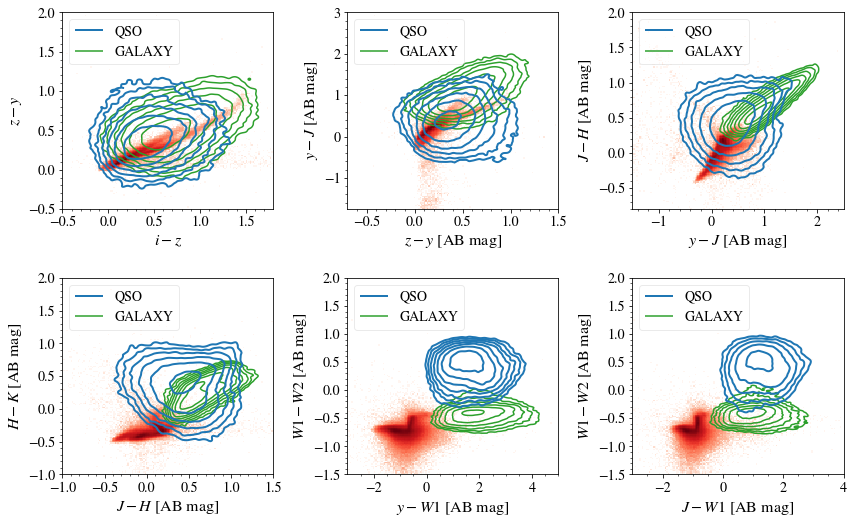

In [102]:
fig, axlist = plt.subplots(2, 3, 
                           figsize=(14 , 8.5))
axlist = axlist.flatten()
fig.subplots_adjust(wspace=0.35, hspace=0.35)
for i, key in enumerate(feature_dict.keys()):
    pair = feature_dict[key]
    fancypairplot(df, 
                  pair['x'], pair['y'],
                  ax=axlist[i], 
                  xrange=pair['xrange'],
                  yrange=pair['yrange'],
                  xlabel=pair['xlabel'], 
                  ylabel=pair['ylabel'])
fig.savefig('/cargo/public/catdata/gpq_nir/color_diagram/trainingset_contour.pdf', 
            dpi=300, 
            bbox_inches='tight')

## 3.2 test6 pred_gpq

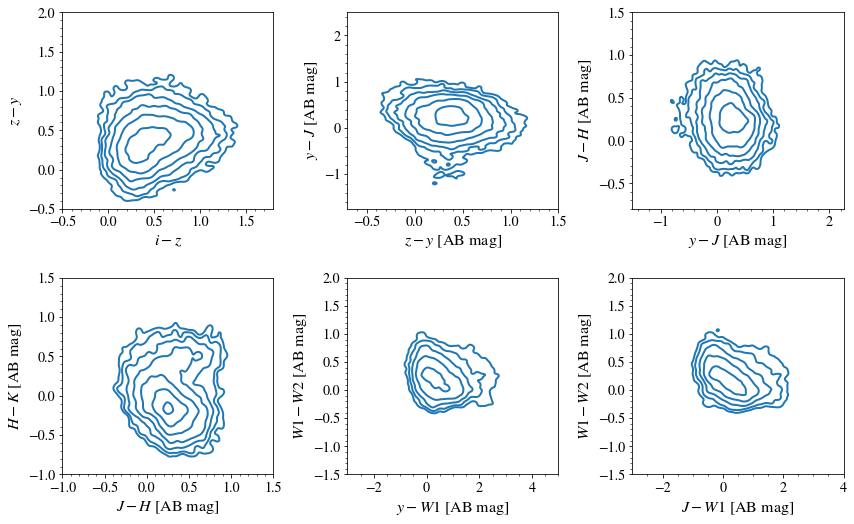

In [94]:
fig, axlist = plt.subplots(2, 3, 
                           figsize=(14 , 8.5))
axlist = axlist.flatten()
fig.subplots_adjust(wspace=0.35, hspace=0.35)
for i, key in enumerate(feature_dict.keys()):
    pair = feature_dict[key]
    fancyplot(pred_gpq, 
                  pair['x'], pair['y'],
                  ax=axlist[i], 
                  xrange=pair['xrange'],
                  yrange=pair['yrange'],
                  xlabel=pair['xlabel'], 
                  ylabel=pair['ylabel'])
# fig.savefig('./plots/sample_ccds_contour_density.pdf', 
#             dpi=300, 
#             bbox_inches='tight')

## 3.3 test6 pred_gpq_30 compare

In [9]:
features = ['iz','zy','yj','jh','hk','iw1','zw1','yw1','jw1','hw1','kw1','w1w2']

MockGPQ = df[df['class']=='QSO'][features]
MockGPQ['class'] = 'MockGPQ'

STAR = df[df['class']=='STAR'][features]
STAR['class'] = 'STAR'

PredGPQ = pred_gpq[features]
PredGPQ['class'] = 'PredGPQ'

<ipython-input-9-8a58082c9e0e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PredGPQ['class'] = 'PredGPQ'


In [10]:
compare = pd.concat([MockGPQ,STAR,PredGPQ])
compare.reset_index(inplace=True,drop=True)
compare

,iz,zy,yj,jh,hk,iw1,zw1,yw1,jw1,hw1,kw1,w1w2,class
0,0.399697,0.300442,0.356291,NaN,NaN,2.504658,2.104961,1.804519,1.448227,NaN,0.758877,0.566922,MockGPQ
1,0.926548,0.212445,0.819954,0.828657,0.719648,4.219157,3.292609,3.080164,2.260210,1.431553,0.711905,0.444344,MockGPQ
2,0.621167,0.398713,0.752156,NaN,NaN,3.687846,3.066679,2.667966,1.915810,NaN,0.881721,0.762600,MockGPQ
3,0.599673,0.283195,0.794577,0.511237,0.251626,2.443748,1.844075,1.560879,0.766303,0.255066,0.003440,0.136549,MockGPQ
4,0.077229,0.567025,0.189591,0.115809,0.432682,1.846869,1.769641,1.202616,1.013025,0.897216,0.464535,0.398674,MockGPQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
625850,0.517900,-0.015500,0.443320,0.282830,NaN,1.843600,1.325700,1.341200,0.897880,0.615050,NaN,0.174000,PredGPQ
625851,0.634000,0.023400,0.566103,NaN,NaN,1.096200,0.462200,0.438800,-0.127303,NaN,NaN,0.638000,PredGPQ
625852,0.176100,0.405000,-0.163939,0.267624,NaN,1.302300,1.126200,0.721200,0.885139,0.617515,NaN,0.435000,PredGPQ
625853,0.629000,0.511800,0.133445,0.489545,-0.226033,2.029400,1.400400,0.888600,0.755155,0.265610,0.491643,0.187000,PredGPQ


<ipython-input-5-ac47fe029c66>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-5-ac47fe029c66>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-5-ac47fe029c66>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-5-ac47fe029c66>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-5-ac47fe029c66>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-5-ac47fe029c66>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


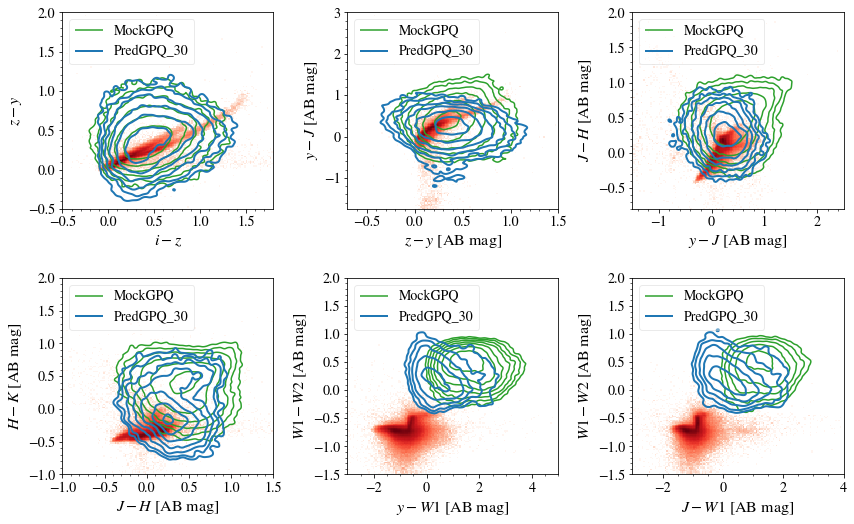

In [13]:
fig, axlist = plt.subplots(2, 3, 
                           figsize=(14 , 8.5))
axlist = axlist.flatten()
fig.subplots_adjust(wspace=0.35, hspace=0.35)
for i, key in enumerate(feature_dict.keys()):
    pair = feature_dict[key]
    fancycompareplot(compare, 
                  pair['x'], pair['y'],
                  ax=axlist[i], 
                  xrange=pair['xrange'],
                  yrange=pair['yrange'],
                  xlabel=pair['xlabel'], 
                  ylabel=pair['ylabel'])
fig.savefig('/cargo/public/catdata/gpq_nir/color_diagram/predGPQ_compare_contour.pdf', 
            dpi=300, 
            bbox_inches='tight')

## 3.4 test6 pred_gpq_30 colorcut
combined_pred_gpq_cut4 = combined_pred_gpq_30.query(  
'iz<1.5 & yj>-0.8\
                                                    & (hk+0.8*jh>0.2)\
                                                    & (w1w2+0.36*yw1>-0.07)\
                                                    & (w1w2+0.33*jw1>0.01)')

In [14]:
pred_gpq_cut1 = pd.read_csv('/cargo/public/catdata/gpq_nir/density_map/combined_pred_gpq_30%_cut5.csv')

In [15]:
features = ['iz','zy','yj','jh','hk','iw1','zw1','yw1','jw1','hw1','kw1','w1w2']

MockGPQ = df[df['class']=='QSO'][features]
MockGPQ['class'] = 'MockGPQ'

STAR = df[df['class']=='STAR'][features]
STAR['class'] = 'STAR'

PredGPQ_cut1 = pred_gpq_cut1[features]
PredGPQ_cut1['class'] = 'PredGPQ'

compare_cut1 = pd.concat([MockGPQ,STAR,PredGPQ_cut1])
compare_cut1.reset_index(inplace=True,drop=True)
compare_cut1

<ipython-input-15-953fab8eba00>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PredGPQ_cut1['class'] = 'PredGPQ'


,iz,zy,yj,jh,hk,iw1,zw1,yw1,jw1,hw1,kw1,w1w2,class
0,0.399697,0.300442,0.356291,NaN,NaN,2.504658,2.104961,1.804519,1.448227,NaN,0.758877,0.566922,MockGPQ
1,0.926548,0.212445,0.819954,0.828657,0.719648,4.219157,3.292609,3.080164,2.260210,1.431553,0.711905,0.444344,MockGPQ
2,0.621167,0.398713,0.752156,NaN,NaN,3.687846,3.066679,2.667966,1.915810,NaN,0.881721,0.762600,MockGPQ
3,0.599673,0.283195,0.794577,0.511237,0.251626,2.443748,1.844075,1.560879,0.766303,0.255066,0.003440,0.136549,MockGPQ
4,0.077229,0.567025,0.189591,0.115809,0.432682,1.846869,1.769641,1.202616,1.013025,0.897216,0.464535,0.398674,MockGPQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
601481,0.571600,0.186200,0.663070,0.493814,0.765884,3.693800,3.122200,2.936000,2.272930,1.779116,1.013232,-0.130000,PredGPQ
601482,0.249100,0.177100,0.282785,0.635797,-0.244579,0.641200,0.392100,0.215000,-0.067785,-0.703582,-0.459003,0.433000,PredGPQ
601483,0.504400,0.410200,0.279546,0.153276,0.276871,2.271600,1.767200,1.357000,1.077454,0.924178,0.647307,-0.079000,PredGPQ
601484,0.997400,0.953900,-0.041660,0.624856,-0.076645,1.889900,0.892500,-0.061400,-0.019740,-0.644596,-0.567951,0.192000,PredGPQ


<ipython-input-16-7346b7af918e>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-16-7346b7af918e>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-16-7346b7af918e>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-16-7346b7af918e>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-16-7346b7af918e>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-16-7346b7af918e>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',


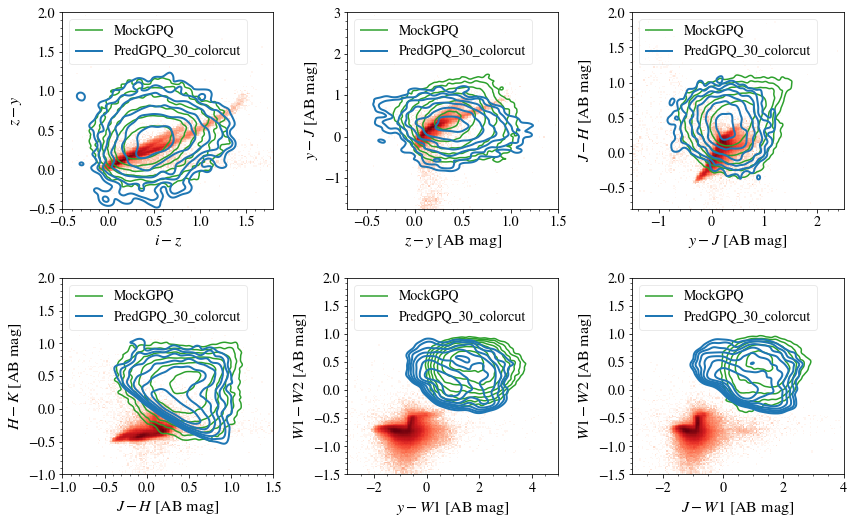

In [17]:
fig, axlist = plt.subplots(2, 3, 
                           figsize=(14 , 8.5))
axlist = axlist.flatten()
fig.subplots_adjust(wspace=0.35, hspace=0.35)
for i, key in enumerate(feature_dict.keys()):
    pair = feature_dict[key]
    fancycompareplot(compare_cut1, 
                  pair['x'], pair['y'],
                  ax=axlist[i], 
                  xrange=pair['xrange'],
                  yrange=pair['yrange'],
                  xlabel=pair['xlabel'], 
                  ylabel=pair['ylabel'])
fig.savefig('/cargo/public/catdata/gpq_nir/color_diagram/predgpq_colorcut_compare_contour_cut5.pdf', 
            dpi=300, 
            bbox_inches='tight')

## 3.5 test6 pred_gpq_all

In [110]:
feature_dict = {}

feature_dict['izy'] = {'x': 'iz', 
                       'y': 'zy',
                       'xrange': [-0.5, 1.8],
                       'yrange': [-0.5, 2.0],
                       'xlabel': r'$i-z$',
                       'ylabel': r'$z-y$'}
feature_dict['zyj'] = {'x': 'zy', 
                       'y': 'yj',
                       'xrange':[-0.7, 1.5],
                       'yrange':[-3.0, 3.0],
                       'xlabel':r"$z-y$ [AB mag]", 
                       'ylabel':r"$y-J$ [AB mag]"}
feature_dict['yjh'] = {'x': 'yj', 
                       'y': 'jh',
                       'xrange':[-3.0, 2.5],
                       'yrange':[-0.8, 2.0],
                       'xlabel':r"$y-J$ [AB mag]", 
                       'ylabel':r"$J-H$ [AB mag]"}
feature_dict['jhk'] = {'x': 'jh', 
                       'y': 'hk',
                      'xrange':[-1, 1.5],
                       'yrange':[-1, 2.0],
                       'xlabel':r"$J-H$ [AB mag]", 
                       'ylabel':r"$H-K$ [AB mag]"}
feature_dict['yw12'] = {'x': 'yw1', 
                       'y': 'w1w2',
                       'xrange':[-3, 5],
                       'yrange':[-1.5,2],
                       'xlabel':r"$y-W1$ [AB mag]", 
                       'ylabel':r"$W1-W2$ [AB mag]"}

feature_dict['jw12'] = {'x': 'jw1', 
                       'y': 'w1w2',
                       'xrange':[-3, 4],
                       'yrange':[-1.5,2],
                       'xlabel':r"$J-W1$ [AB mag]", 
                       'ylabel':r"$W1-W2$ [AB mag]"}



<ipython-input-112-472d82b6fc0d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PredGPQ_all['class'] = 'PredGPQ'
<ipython-input-34-34c4e5732d20>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-34-34c4e5732d20>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-34-34c4e5732d20>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-34-34c4e5732d20>:49: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(H).T, origin='lower',
<ipython-input-34-34c4e5732d20>:49: RuntimeWarning: divide by zero encountered in log10
  im = a

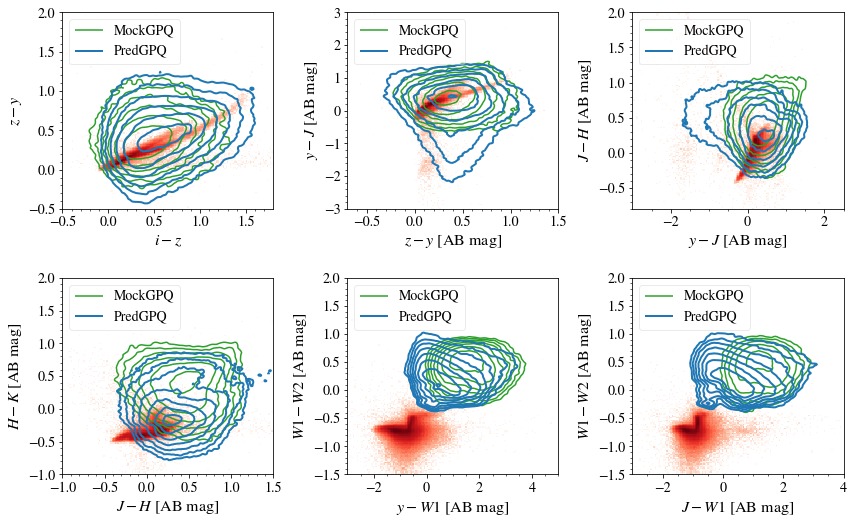

In [112]:
pred_gpq_all = pd.read_csv('/cargo/public/catdata/gpq_nir/density_map/P_real.csv')

features = ['iz','zy','yj','jh','hk','iw1','zw1','yw1','jw1','hw1','kw1','w1w2']

MockGPQ = df[df['class']=='QSO'][features]
MockGPQ['class'] = 'MockGPQ'

STAR = df[df['class']=='STAR'][features]
STAR['class'] = 'STAR'

PredGPQ_all = pred_gpq_all[features]
PredGPQ_all['class'] = 'PredGPQ'

compare_all = pd.concat([MockGPQ,STAR,PredGPQ_all])
compare_all.reset_index(inplace=True,drop=True)
compare_all

fig, axlist = plt.subplots(2, 3, 
                           figsize=(14 , 8.5))
axlist = axlist.flatten()
fig.subplots_adjust(wspace=0.35, hspace=0.35)
for i, key in enumerate(feature_dict.keys()):
    pair = feature_dict[key]
    fancycompareplot(compare_all, 
                  pair['x'], pair['y'],
                  ax=axlist[i], 
                  xrange=pair['xrange'],
                  yrange=pair['yrange'],
                  xlabel=pair['xlabel'], 
                  ylabel=pair['ylabel'])
fig.savefig('/cargo/public/catdata/gpq_nir/color_diagram/predgpq_all_compare_contour.pdf', 
            dpi=300, 
            bbox_inches='tight')